In [21]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

Import the dataframes: 

In [22]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_absolute_otu_1seqin3samps.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_relative_1seqin3samps.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/Nov2017_Filtering/1seq_in_3samples/nochloro_HNA_LNA_1seqin3samps.tsv', sep= ' ', index_col=0, header=0)

**2)**: At 01-05-'17 @marschmi found that a few samples can be seen as outliers, as they represent the bottom waters of productive inland lakes, resulting in a big difference of the HNA percentage. These samples are the following: Z14055F, Z14003F, Z14007F, Z14023F, Z14011F. A code of line is added, in order to be able to run the pipeline without these samples; 

In [23]:
#samples_to_drop = ['Z14055F', 'Z14003F', 'Z14007F', 'Z14023F', 'Z14011F']
#index = target.index.drop(samples_to_drop)

In [24]:
'''Set sample names as index and shuffle data'''
index = data_rel.index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
#productivity = productivity.loc[index,:]

#Shuffle data: 
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [25]:
#Some variables to store information and to create inner and outer CV-folds

data_rel = data_rel.loc[:, (data_rel != 0).any(axis=0)]
otus = list(data_rel.columns)

#cv_out = 10
cv = 5
#outer_cv = KFold(n_splits=cv_out, shuffle=False)

#otu_scores_cv = pd.DataFrame(columns=otus)
#r2_cv = np.zeros(cv_out)
#thresholds_cv = np.zeros(cv_out)

#pred = pd.Series(index=data_abs.index)
#final_scores = pd.DataFrame(columns=otus)

#thresholds = np.arange(0,1,0.01)
#t = 0

In [26]:
''' Log-Ratio analyses '''
min_bact = data_rel.loc[:,otus].min()[data_rel.loc[:,otus].min() > 0]
min_bact = min_bact.min()
data_rel.replace(0,min_bact,inplace=True)
data_rel_clr = pd.DataFrame(composition.clr(data_rel.loc[:,otus]), columns=otus)

''' Standardize data '''
from analysis_functions import standardize_df
data_stand, scaler = standardize_df(data_rel_clr,otus)

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

**Univariate Feature Selection**: 

Let's compare two methods: 
- f_regression (f-score pearson correlation), 
- Mutual information,  
- (other methods can follow as well). 

In [27]:
f_regr, f_regr_p = f_regression(data_stand.loc[:,otus],hna)
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],hna, axis=0)
uni_fs = pd.DataFrame(f_regr, index=otus, columns = ['f_regr'])
uni_fs['p-value'] = f_regr_p
uni_fs['r_spearman'] = r_spearman
uni_fs['p_spearman'] = p_spearman
#uni_fs['mi'] = mutual_info_regression(data_stand.loc[:,otus],hna)
#uni_fs.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,68.655384,3.761016e-14,-0.617921,4.554200e-19
Otu000004,0.482054,4.884641e-01,-0.114107,1.408152e-01
Otu000005,7.657785,6.294591e-03,0.236633,2.013734e-03
Otu000006,6.932621,9.262960e-03,-0.272270,3.564744e-04
Otu000007,1.825478,1.785012e-01,-0.127472,9.963722e-02
Otu000009,1.586476,2.095984e-01,0.085153,2.724364e-01
Otu000010,4.168932,4.275442e-02,0.187162,1.512812e-02
Otu000011,0.868124,3.528283e-01,0.049418,5.246900e-01
Otu000012,0.100972,7.510657e-01,-0.007380,9.243602e-01
Otu000014,0.484458,4.873831e-01,-0.436961,3.184659e-09


In [28]:
#uni_fs.to_csv('F_test_spearman_hna_1seq3.csv')

Select otu's based on $p < \text{thr}$: 

In [29]:
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs using F-test with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs using F-test with p < 0.01: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs[uni_fs.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs using F-test with p < 0.05: 1436
Number of selected OTUs using F-test with p < 0.01: 1114
Number of selected OTUs using spearman correlation with p < 0.05: 2852
Number of selected OTUs using spearman correlation with p < 0.01: 2825


What happens when we tune a threshold in function of the f_score: 

In [30]:
from analysis_functions import get_r2_scores
#thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['f_regr'], cv)
#thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['f_regr'], cv)

In [31]:
#plt.figure()
#sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.xlabel('F-score', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('F-test', size=24)
#plt.legend()
#plt.show()

In [32]:
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs['r_spearman']), cv)
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs['r_spearman']), cv)

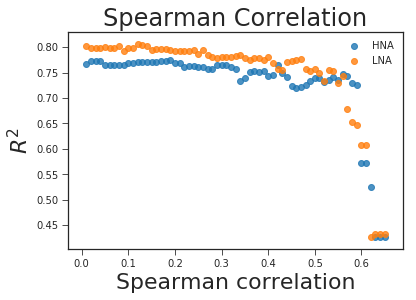

In [33]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman Correlation', size=24)
plt.legend()
plt.show()

In [34]:
#uni_fs.sort_values(ascending=False,inplace=True, by='mi')
#display(uni_fs.head(10))
#thr_otu_mi_hna, r2_otu_mi_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs['mi'], cv)
#thr_otu_mi_lna, r2_otu_mi_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs['mi'], cv)

In [35]:
#plt.figure()
#sns.regplot(x=thr_otu_mi_hna,y=r2_otu_mi_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_mi_lna,y=r2_otu_mi_lna, fit_reg=False, label='LNA')
#plt.xlabel('MI', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('Mutual Information', size=24)
#plt.legend()
#plt.show()

In [36]:
from analysis_functions import get_lassoCV_alpha

alpha = get_lassoCV_alpha(data_stand.loc[:,otus],hna,otus,cv)
    
otu_scores = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], hna, alpha), index=otus, columns=['score'])
otu_scores.sort_values(ascending=False,inplace=True, by='score')

thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores, cv)
thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


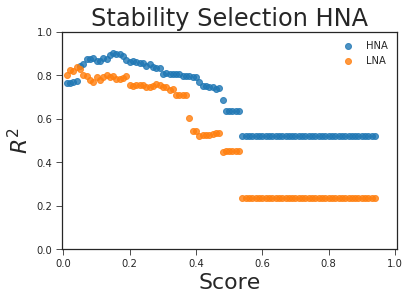

In [37]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection HNA', size=24)
plt.show()

In [38]:
r2_final = r2_otu_scores_hna.max()
thr = thr_otu_scores_hna[r2_otu_scores_hna.argmax()]
print('R²_cv(hna): ' + str(r2_final) )
print('Threshold score: ' + str(thr))

R²_cv(hna): 0.90174868086
Threshold score: 0.15


In [39]:
otu_scores = otu_scores.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores =  otu_scores.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores = otu_scores.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores['r_spearman'] = uni_fs.loc[otu_scores.index,'r_spearman']
otu_scores['p_spearman'] = uni_fs.loc[otu_scores.index,'p_spearman']
otu_scores.to_csv('Final/hnascores_otus_1seq3_aitch.csv')

In [40]:
otu_scores_selected = otu_scores[otu_scores.score.values>thr]
selected_otus = otu_scores_selected.index
otu_scores_selected.to_csv('Final/hnascores_otus_tuned_thr_'+str(thr)+'_1seq3_aitch.csv')
display(otu_scores_selected.head(10))
print('Size list selected OTUs: ' + str(len(selected_otus)))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000173,0.933333,8892.157986,1.953307,0.001341,1.608728,0.584326,9.190074e-17
Otu000060,0.530000,26355.897534,1.500728,0.003868,1.065044,0.645105,3.805779e-21
Otu000001,0.473333,371601.089939,0.720490,0.095239,0.631085,-0.617921,4.554200e-19
Otu000137,0.470000,3084.664828,1.846876,0.001571,2.438489,-0.550541,1.066727e-14
Otu000271,0.463333,8243.279639,2.237866,0.001160,1.795649,0.423302,1.085970e-08
Otu000335,0.456667,6250.999417,2.165661,0.000998,1.586541,0.345536,4.489698e-06
Otu000917,0.450000,1381.202341,4.344537,0.000339,1.546553,-0.206518,7.235268e-03
Otu000169,0.436667,14088.743045,1.751057,0.002264,1.641773,0.494748,9.321643e-12
Otu000242,0.430000,5280.016814,3.481944,0.000844,2.282544,0.036561,6.379963e-01
Otu000981,0.426667,631.164361,4.614274,0.000289,1.513578,-0.385111,2.542244e-07


Size list selected OTUs: 122


In [41]:
print('R²_cv of HNA-selected OTUs in function of LNA: ' + str(r2_otu_scores_lna[r2_otu_scores_hna.argmax()]) )

R²_cv of HNA-selected OTUs in function of LNA: 0.795649637823


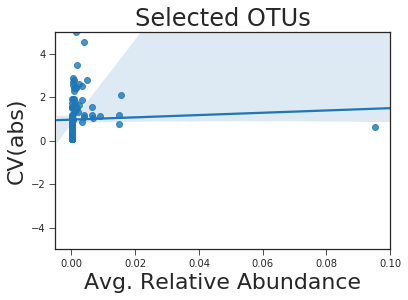

In [42]:
plt.figure()
sns.regplot(x='abun_rel_mean',y='abun_rel_CV', data=otu_scores_selected)
plt.axis([-0.005,0.1,-5,5])
plt.xlabel('Avg. Relative Abundance', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.title('Selected OTUs', size=24)
plt.show()

In [43]:
#optimal_scores.to_csv('HNA_selectedOTUs_stand_abun_remov' + str(abun)+'_R2'+str(r2_final)+'.csv')

**Second goal**: Can we use the same pipeline to predict the _LNA_-counts? 

In [44]:
f_regr_lna, f_regr_p_lna = f_regression(data_stand.loc[:,otus],lna)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p_lna
r_spearman = np.zeros(len(otus))
p_spearman = np.zeros(len(otus))
for i in np.arange(0,len(otus)):
    r_spearman[i], p_spearman[i] = spearmanr(data_stand.loc[:,otus[i]],lna, axis=0)
uni_fs_lna = pd.DataFrame(f_regr_lna, index=otus, columns = ['f_regr'])
uni_fs_lna['p-value'] = f_regr_p
uni_fs_lna['r_spearman'] = r_spearman
uni_fs_lna['p_spearman'] = p_spearman
#uni_fs_lna['mi'] = mutual_info_regression(data_stand.loc[:,otus],lna)
#uni_fs_lna.sort_values(ascending=False,inplace=True, by='f_regr')
display(uni_fs_lna.head(10))

,f_regr,p-value,r_spearman,p_spearman
Otu000001,10.444085,3.761016e-14,-0.401486,6.903038e-08
Otu000004,1.169080,4.884641e-01,-0.078609,3.111340e-01
Otu000005,52.000984,6.294591e-03,0.486564,2.278979e-11
Otu000006,4.264646,9.262960e-03,-0.192703,1.232977e-02
Otu000007,1.623283,1.785012e-01,-0.095069,2.202670e-01
Otu000009,0.020666,2.095984e-01,-0.006965,9.286027e-01
Otu000010,22.200575,4.275442e-02,0.355751,2.219062e-06
Otu000011,0.148582,3.528283e-01,-0.008635,9.115428e-01
Otu000012,1.937502,7.510657e-01,0.088266,2.552274e-01
Otu000014,2.632151,4.873831e-01,-0.409853,3.449363e-08


In [45]:
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.05]
print('Number of selected OTUs with p < 0.05: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f_lna = uni_fs_lna[uni_fs_lna.loc[:,'p-value'].values < 0.01]
print('Number of selected OTUs with p < 0.01: ' + str(len(uni_fs_selected_f_lna)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.05]
print('Number of selected OTUs using spearman correlation with p < 0.05: ' + str(len(uni_fs_selected_f)))
uni_fs_selected_f = uni_fs_lna[uni_fs_lna.loc[:,'p_spearman'].values < 0.01]
print('Number of selected OTUs using spearman correlation with p < 0.01: ' + str(len(uni_fs_selected_f)))

Number of selected OTUs with p < 0.05: 1436
Number of selected OTUs with p < 0.01: 1114
Number of selected OTUs using spearman correlation with p < 0.05: 2843
Number of selected OTUs using spearman correlation with p < 0.01: 2808


In [46]:
#uni_fs.to_csv('F_test_spearman_lna_1seq3.csv')

In [47]:
#thr_otu_f_regr_lna, r2_otu_f_regr_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, uni_fs_lna['f_regr'], cv)
#thr_otu_f_regr_hna, r2_otu_f_regr_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, uni_fs_lna['f_regr'], cv)

In [48]:
#plt.figure()
#sns.regplot(x=thr_otu_f_regr_hna,y=r2_otu_f_regr_hna, fit_reg=False, label='HNA')
#sns.regplot(x=thr_otu_f_regr_lna,y=r2_otu_f_regr_lna, fit_reg=False, label='LNA')
#plt.axis([-0.005,1.005,0,1])
#plt.xlabel('F-score', size=22)
#plt.xticks(size=10)
#plt.ylabel(r'$R^2$', size=22)
#plt.yticks(size=10)
#plt.title('F-test', size=24)
#plt.legend()
#plt.show()

In [49]:
thr_otu_sp_lna, r2_otu_sp_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)
thr_otu_sp_hna, r2_otu_sp_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, np.absolute(uni_fs_lna['r_spearman']), cv)

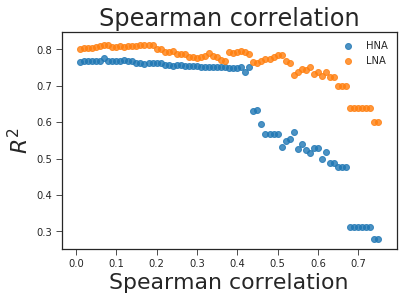

In [50]:
plt.figure()
sns.regplot(x=thr_otu_sp_hna,y=r2_otu_sp_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_sp_lna,y=r2_otu_sp_lna, fit_reg=False, label='LNA')
plt.xlabel('Spearman correlation', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.title('Spearman correlation', size=24)
plt.legend()
plt.show()

In [51]:
alpha = get_lassoCV_alpha(data_stand.loc[:,otus],lna,otus,cv)
otu_scores_lna = pd.DataFrame(perform_randomizedLasso(data_stand.loc[:,otus], lna, alpha), index=otus, columns=['score'])
otu_scores_lna.sort_values(ascending=False, inplace=True, by='score')

thr_otu_scores_lna, r2_otu_scores_lna = get_r2_scores(data_stand.loc[:,otus], lna, otus, otu_scores_lna, cv)
thr_otu_scores_hna, r2_otu_scores_hna = get_r2_scores(data_stand.loc[:,otus], hna, otus, otu_scores_lna, cv)

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


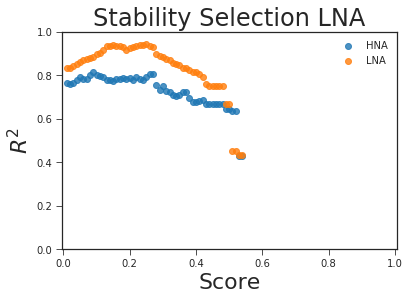

In [52]:
plt.figure()
sns.regplot(x=thr_otu_scores_hna,y=r2_otu_scores_hna, fit_reg=False, label='HNA')
sns.regplot(x=thr_otu_scores_lna,y=r2_otu_scores_lna, fit_reg=False, label='LNA')
plt.axis([-0.005,1.005,0,1])
plt.xlabel('Score', size=22)
plt.xticks(size=10)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.legend()
plt.title('Stability Selection LNA', size=24)
plt.show()

In [53]:
r2_final = r2_otu_scores_lna.max()
thr_lna = thr_otu_scores_lna[r2_otu_scores_lna.argmax()]
print('R²_cv(lna): ' + str(r2_final) )
print('Threshold score: ' + str(thr_lna))

R²_cv(lna): 0.941913772943
Threshold score: 0.25


In [54]:
otu_scores_lna = otu_scores_lna.assign(abun_abs_mean = data_abs.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_abs_CV = data_abs.loc[:,otus].std()/data_abs.loc[:,otus].mean())
otu_scores_lna =  otu_scores_lna.assign(abun_rel_mean = data_rel.loc[:,otus].mean())
otu_scores_lna = otu_scores_lna.assign(abun_rel_CV = data_rel.loc[:,otus].std()/data_rel.loc[:,otus].mean())
otu_scores_lna['r_spearman'] = uni_fs_lna.loc[otu_scores.index,'r_spearman']
otu_scores_lna['p_spearman'] = uni_fs_lna.loc[otu_scores.index,'p_spearman']
otu_scores_lna.to_csv('Final/lnascores_otus_abun_1seq3_aitch.csv')


In [55]:
otu_scores_selected_lna = otu_scores_lna[otu_scores_lna.score.values>thr_lna]
selected_otus_lna = otu_scores_selected_lna.index
print('Size list selected OTUs: ' + str(len(selected_otus_lna)))
otu_scores_selected_lna.to_csv('Final/lnascores_otus_tuned_thr_'+str(thr_lna)+'_1seq3_aitch.csv')
display(otu_scores_selected_lna.head(10))

Size list selected OTUs: 72


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000060,0.533333,26355.897534,1.500728,0.003868,1.065044,0.662208,1.451306e-22
Otu000173,0.520000,8892.157986,1.953307,0.001341,1.608728,0.423953,1.025607e-08
Otu000392,0.500000,4464.972546,2.231505,0.000769,1.678326,0.181493,1.855029e-02
Otu000108,0.496667,16074.992429,2.334943,0.002182,1.913854,0.524084,3.090445e-13
Otu000027,0.473333,24746.384748,1.224870,0.008914,1.135761,-0.747658,2.538449e-31
Otu000749,0.430000,697.785592,3.755242,0.000267,0.866951,-0.230668,2.628427e-03
Otu000056,0.420000,3439.903832,3.855871,0.004029,4.548170,-0.596935,1.348193e-17
Otu000523,0.416667,2411.089795,3.440686,0.000433,1.954305,0.060090,4.390823e-01
Otu000597,0.416667,2065.701352,2.297885,0.000450,1.296047,0.047188,5.435869e-01
Otu000175,0.413333,23301.415981,2.040045,0.003293,1.881811,0.396698,1.018083e-07


In [56]:
print('R²_cv of LNA-selected OTUs in function of HNA: ' + str(r2_otu_scores_hna[r2_otu_scores_lna.argmax()]) )

R²_cv of LNA-selected OTUs in function of HNA: 0.791858603329


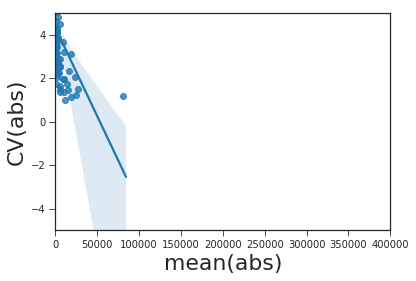

In [57]:
plt.figure()
sns.regplot(x='abun_abs_mean',y='abun_abs_CV', data=otu_scores_selected_lna)
plt.axis([0,400000,-5,5])
plt.xlabel('mean(abs)', size=22)
plt.xticks(size=10)
plt.ylabel('CV(abs)', size=22)
plt.yticks(size=10)
plt.show()

Let's compare the HNA- and LNA-lists, which OTU's are shared (_common_) and which are only part of the HNA- or LNA subset?: 

In [58]:
idx_hna = otu_scores_selected.index.difference(otu_scores_selected_lna.index)
idx_lna = otu_scores_selected_lna.index.difference(otu_scores_selected.index)
idx_common = otu_scores_selected.drop(idx_hna).index
pd.Series(idx_common).to_csv('commonOTU_HNALNA_abun.001_rel.csv')
print('Size subset OTUs only related to HNA: ' + str(len(idx_hna)) + '; opposed to total size: ' + str(len(otu_scores_selected)))
print('Size subset OTUs only related to LNA: ' + str(len(idx_lna)) + '; opposed to total size: ' + str(len(otu_scores_selected_lna)))
print('Size subset OTUs related to both: ' + str(len(idx_common)))

display(otu_scores_selected_lna.loc[idx_common,:].head(10))
#data_abs_raw = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
#data_abs_raw = data_abs_raw.loc[index,:]
#display(data_abs_raw.loc[:,idx_hna].sum(axis=1).values/hna.values)

Size subset OTUs only related to HNA: 93; opposed to total size: 122
Size subset OTUs only related to LNA: 43; opposed to total size: 72
Size subset OTUs related to both: 29


,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,r_spearman,p_spearman
Otu000173,0.520000,8892.157986,1.953307,0.001341,1.608728,0.423953,1.025607e-08
Otu000060,0.533333,26355.897534,1.500728,0.003868,1.065044,0.662208,1.451306e-22
Otu000169,0.370000,14088.743045,1.751057,0.002264,1.641773,0.451650,8.001820e-10
Otu000682,0.296667,1290.985248,4.090973,0.000336,1.543052,-0.291786,1.242474e-04
Otu000088,0.380000,5087.595794,1.342708,0.001895,1.484309,-0.504019,3.289425e-12
Otu000027,0.473333,24746.384748,1.224870,0.008914,1.135761,-0.747658,2.538449e-31
Otu000292,0.270000,1016.626011,2.612459,0.000537,1.896467,-0.503485,3.495821e-12
Otu003885,0.296667,18.391432,5.867267,0.000214,0.076695,-0.536161,6.894136e-14
Otu000313,0.260000,2492.843861,2.222905,0.000470,1.223782,0.183270,1.741195e-02
Otu000056,0.420000,3439.903832,3.855871,0.004029,4.548170,-0.596935,1.348193e-17


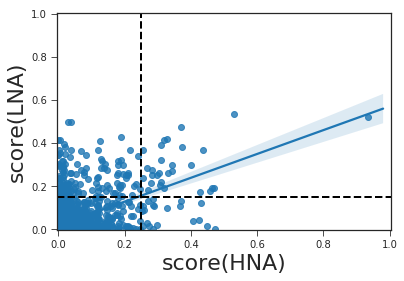

In [59]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=otu_scores_lna.loc[otu_scores.index,'score'])
plt.axis([-0.005,1.005,-0.005,1.005])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('score(LNA)', size=22)
plt.yticks(size=10)
plt.axhline(y=thr, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
plt.show()

This figure shows 4 area's: 
- (left top corner): OTU's selected solely in function of **LNA**-dynamics, 
- (right top corner): OTU's selected in function of both **HNA**- and **LNA**-dynamics, 
- (left bottom corner): OTU's that are _not_ selected, 
- (right bottom corner): OTU's selected solely in function of **HNA**-dynamics. 

Univariate vs. Stability selection

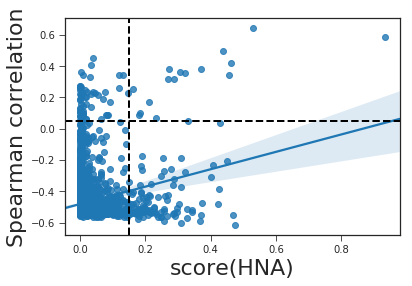

In [60]:
plt.figure()
sns.regplot(x=otu_scores.loc[:,'score'],y=uni_fs.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

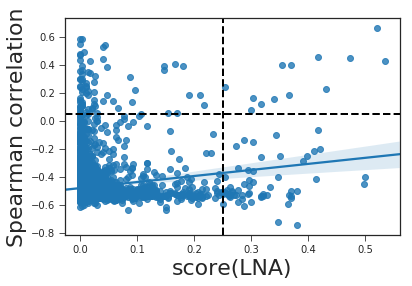

In [61]:
plt.figure()
sns.regplot(x=otu_scores_lna.loc[:,'score'],y=uni_fs_lna.loc[otu_scores.index,'r_spearman'])
plt.xlabel('score(LNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Spearman correlation', size=22)
plt.yticks(size=10)
#plt.yscale('log')
plt.axhline(y=0.05, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=thr_lna, linewidth=2, linestyle='--', color = 'k')
#plt.axis([-0.005,1.005,0.0000000000000000000001, 1])
plt.show()

This analysis shows that the HNA/LNA dynamics cannot solely be attributed to OTU's that are present in the respective cloud; this is also clear from the mutual correlation between HNA- and LNA-counts ( $\rho(\text{HNA,LNA}) = 0.75$ ). 

I see two reasons for this: 
- Some OTU's are simply present in the two clouds; 
- Some HNA-OTU's interact with LNA-OTU's and vice versa. 